<a href="https://colab.research.google.com/github/0xtaha/image-super-resloution-for-remote-sensing/blob/main/colab_notebooks/image_super_resolution_using_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading The repo files

In [ ]:
!git clone https://github.com/0xtaha/image-super-resloution-for-remote-sensing

Cloning into 'image-super-resloution-for-remote-sensing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 43 (delta 13), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [ ]:
!cp -a /content/image-super-resloution-for-remote-sensing/. /content/
!rm -rf /content/image-super-resloution-for-remote-sensing/

## imporintg required packages

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
import os
from tqdm.notebook import tqdm, trange
from skimage.transform import resize
from matplotlib import pyplot
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pandas as pd

## 1.Downloading The Dataset

In [ ]:
!wget  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip /content/UCMerced_LandUse.zip -d /content/;

--2021-04-15 17:45:46--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  35.1MB/s    in 12s     

2021-04-15 17:45:59 (25.5 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]

Archive:  /content/UCMerced_LandUse.zip
   creating: /content/UCMerced_LandUse/Images/
   creating: /content/UCMerced_LandUse/Images/agricultural/
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: /content/UCMerced_LandUse/Images

In [ ]:
dataset_path = '/content/UCMerced_LandUse'
unziped_dataset_images_path = '/content/UCMerced_LandUse/Images/**/*.tif'
os.remove("/content/UCMerced_LandUse.zip")

In [ ]:
Land_images = glob.glob(unziped_dataset_images_path) #returns path of images
print(len(Land_images)) #contains 13243 images

2100


## 2.Preprocessing

In [ ]:
preprocessed_data_path = '/content/preprocessed/'
number_of_images = 2100
train_images, test_images = train_test_split(Land_images[:number_of_images], random_state = 32, test_size=0.2 , train_size = 0.8)

In [ ]:
remove_images = Land_images[number_of_images+1:]
for im in remove_images:
  os.remove(im)

In [ ]:
%%bash
mkdir /content/preprocessed/
mkdir /content/preprocessed/train_x/
mkdir /content/preprocessed/train_y/
mkdir /content/preprocessed/test_x/
mkdir /content/preprocessed/test_y/

In [ ]:
from Preprocessing import Data_Preprocessing , pixalate_image
# Data_Preprocessing(images_list ,path, Preprocessed_Data_Path , pixelation_scale = 40 ,DownSamplingMode = cv2.INTER_AREA  )

In [ ]:
Data_Preprocessing(train_images ,'train', preprocessed_data_path , pixelation_scale = 40 , DownSamplingMode = cv2.INTER_AREA )

Done ... 


In [ ]:
Data_Preprocessing(test_images ,'test', preprocessed_data_path , pixelation_scale = 40 , DownSamplingMode = cv2.INTER_NEAREST )

Done ... 


In [ ]:
!rm -rf /content/UCMerced_LandUse

In [ ]:
x_train_list = sorted(glob.glob(os.path.join(preprocessed_data_path, 'train_x', '*.npy')))
y_train_list = sorted(glob.glob(os.path.join(preprocessed_data_path, 'train_y', '*.npy')))
x_test_list = sorted(glob.glob(os.path.join(preprocessed_data_path, 'test_x', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(preprocessed_data_path, 'test_y', '*.npy')))

print(len(x_train_list), len(x_test_list))
print(x_train_list[0])

1680 420
/content/preprocessed/train_x/agricultural00.npy


In [ ]:
x_val_list = x_train_list[1501:]
y_val_list = y_train_list[1501:]
x_train_list = x_train_list[:1500]
y_train_list = y_train_list[:1500]

In [ ]:
from DataGenerator import DataGenerator

train_gen = DataGenerator(list_x=x_train_list, list_y= y_train_list, labels=None, batch_size=20, dim=(256,256), n_channels=3, n_classes=None, shuffle=True)
val_gen = DataGenerator(list_x=x_val_list, list_y= y_val_list, labels=None, batch_size=20, dim=(256,256), n_channels=3, n_classes=None, shuffle=False)

## Combining Loss Functions

Let's try using a loss that doesn't just tell us the pixel-wise difference in resolution, but that also if there's an improvement, for example, in high frequency details.

### MSE and HFENN

We can do a weight sum of both losses like:

$MSE + weight * HFENN$

We could choose $weight = 10$ and see what happens. 

The HFENN (High Frequency Error Norm Normalized) metric gives  a  measure  of how high-frequency details differ between two images.

This means that we can guess if an image has more or less high frequency details (which are fine details that you need to zoom in to see and that are not blurry) compared to another image.

When the output value is 0 the images are identical. The greater the value, the more of a perceptual difference in both images there is.

In [ ]:
from loss import hfenn_loss , ae_loss

## 3. Metrics

In [ ]:
def ssim(y_pred, y_true):
  return tf.image.ssim(y_true, y_pred , max_val=2.0)

def psnr(y_pred, y_true):
  return tf.image.psnr(y_true, y_pred , max_val=1.0)

## 3. Model Archticture

In [ ]:
from models import Autoencoder
autoencoder = Autoencoder()

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
autoencoder.compile(optimizer='adam', loss=[ae_loss], metrics=[ssim,psnr,'accuracy'])

## 4. Training

In [ ]:
history = autoencoder.fit(train_gen, validation_data=val_gen,
            epochs=60,
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/60
75/75 [==============================] - 184s 2s/step - loss: 0.0875 - ssim: 0.6523 - psnr: 18.1580 - accuracy: 0.5286 - val_loss: 0.0073 - val_ssim: 0.9053 - val_psnr: 28.6032 - val_accuracy: 0.8887
Epoch 2/60
75/75 [==============================] - 88s 1s/step - loss: 0.0068 - ssim: 0.9020 - psnr: 28.8858 - accuracy: 0.8751 - val_loss: 0.0065 - val_ssim: 0.9101 - val_psnr: 29.2545 - val_accuracy: 0.8878
Epoch 3/60
75/75 [==============================] - 48s 638ms/step - loss: 0.0062 - ssim: 0.9025 - psnr: 29.2407 - accuracy: 0.8820 - val_loss: 0.0060 - val_ssim: 0.9129 - val_psnr: 29.5349 - val_accuracy: 0.8933
Epoch 4/60
75/75 [==============================] - 47s 630ms/step - loss: 0.0055 - ssim: 0.9072 - psnr: 29.7455 - accuracy: 0.8852 - val_loss: 0.0058 - val_ssim: 0.9151 - val_psnr: 29.6660 - val_accuracy: 0.8918
Epoch 5/60
75/75 [==============================] - 47s 633ms/step - loss: 0.0059 - ssim: 0.9070 - psnr: 29.5391 - accuracy: 0.8890 - val_loss: 0.0057 - 

## 5. Results

In [ ]:
# Test
x_test_images = []
y_test_images = []

bar = tqdm(total= len(x_test_list[:1000]), position=0)
for x_image in x_test_list[:1000] :
  x_test_images.append(np.load(x_image))
  bar.update(1)
bar_2 = tqdm(total= len(x_test_list[:1000]), position=0)
for y_image in y_test_list[:1000]:
  y_test_images.append(np.load(y_image[:1000]))
  bar_2.update(1)

x_test_images = np.array(x_test_images)
y_test_images = np.array(y_test_images)

In [ ]:
results = autoencoder.evaluate(x_test_images, y_test_images)
print('test_loss, test_accuracy', results)

14/14 [==============================] - 15s 410ms/step - loss: 0.1243 - ssim: 0.5551 - psnr: 19.0551 - accuracy: 0.7672
test_loss, test_accuracy [0.1242976039648056, 0.5550889372825623, 19.055070877075195, 0.7672141194343567]


In [ ]:
predictions = autoencoder.predict(x_test_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


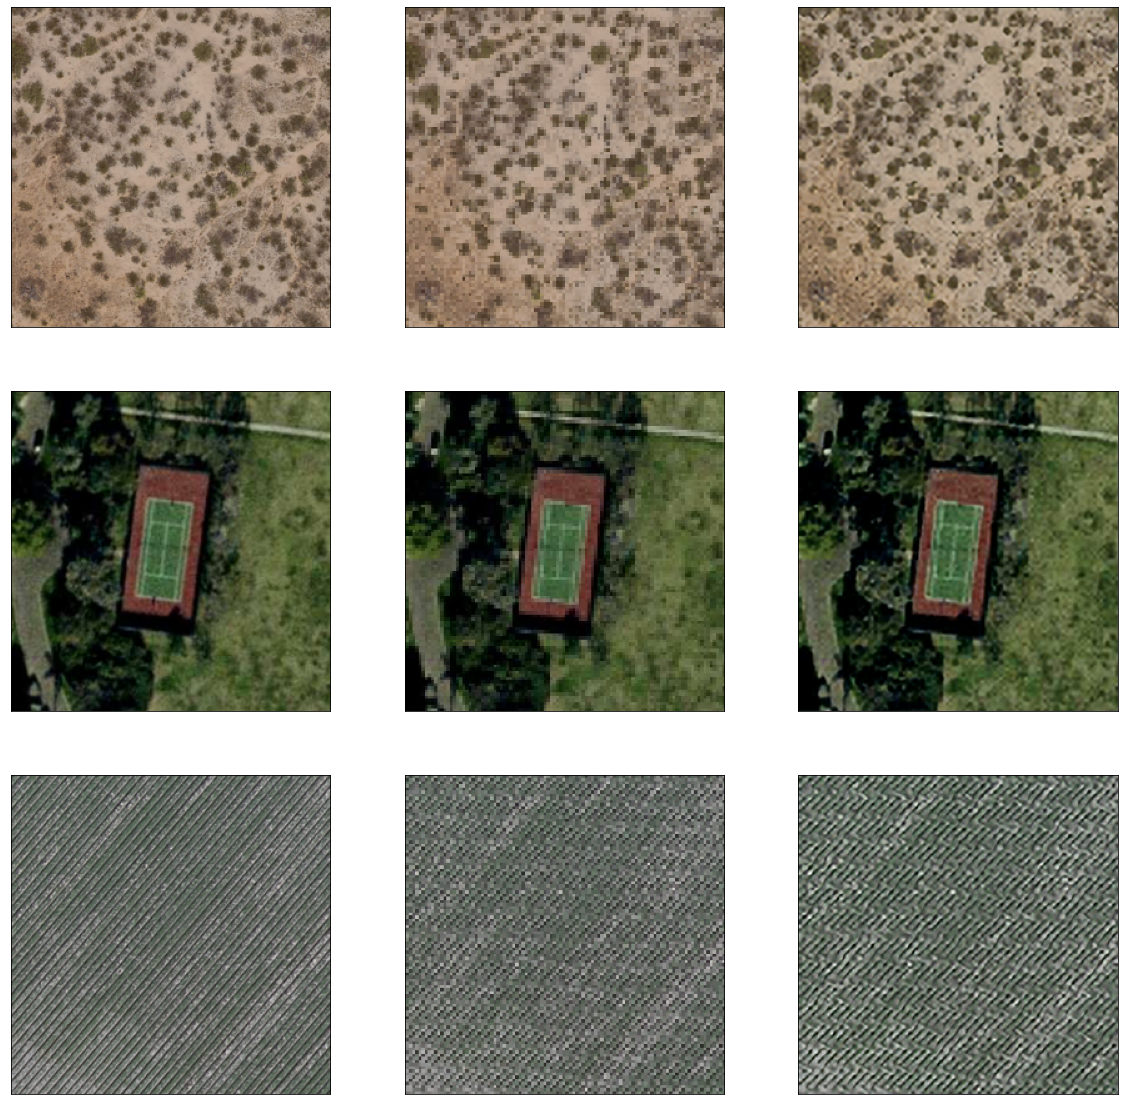

In [ ]:
from random import randint
av = len(x_test_images)
n = 3
fig, axs = plt.subplots(n, 3, figsize=(20, 20))
if n == 1 :
  example = randint(0,av)
  axs[0].imshow(y_test_images[example])
  axs[0].get_xaxis().set_visible(False)
  axs[0].get_yaxis().set_visible(False)

  axs[1].imshow(x_test_images[example])
  axs[1].get_xaxis().set_visible(False)
  axs[1].get_yaxis().set_visible(False)

  axs[2].imshow(predictions[example])
  axs[2].get_xaxis().set_visible(False)
  axs[2].get_yaxis().set_visible(False)
else :
  for i in range(n):
    example = randint(0,av)
    axs[i][0].imshow(y_test_images[example])
    axs[i][0].get_xaxis().set_visible(False)
    axs[i][0].get_yaxis().set_visible(False)

    axs[i][1].imshow(x_test_images[example])
    axs[i][1].get_xaxis().set_visible(False)
    axs[i][1].get_yaxis().set_visible(False)

    axs[i][2].imshow(predictions[example])
    axs[i][2].get_xaxis().set_visible(False)
    axs[i][2].get_yaxis().set_visible(False)
plt.show()

In [ ]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)

In [ ]:
ssim = list(map(SSIM,predictions,x_test_images))
mse = list(map(mse, predictions, x_test_images))
Psnr = list(map(Psnr , predictions , x_test_images))

In [ ]:
metrics = pd.DataFrame(list(zip(ssim, Psnr, mse)), 
               columns =['SSIM','PSNR', 'mse' ]) 

In [ ]:
metrics.head()

,SSIM,PSNR,mse
0,0.896686,26.633448,0.006513
1,0.799703,21.552118,0.020985
2,0.937275,32.819378,0.001567
3,0.913672,30.908949,0.002433
4,0.921935,31.065607,0.002347


In [ ]:
metrics.mean(axis = 0)

SSIM     0.910806
PSNR    27.053938
mse      0.008438
dtype: float64